In [1]:
using Statistics, Lux, MLUtils, OneHotArrays, MLDatasets, Plots
using Base: @kwdef
using Random: Xoshiro

In [2]:
using Pkg

In [3]:
include("src/network.jl")
include("src/vsa.jl")
include("src/spiking.jl")

zero_nans (generic function with 1 method)

In [4]:
#dim_vsa, time samples, batch

In [6]:
q = random_symbols((512, 32, 1))
k = random_symbols((512, 20, 1))
v = random_symbols((512, 20, 1));

In [7]:
sa = SpikingArgs()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.02 (V)


In [8]:
tspan = (0.0, 10.0)

(0.0, 10.0)

In [9]:
to_spk = x -> phase_to_train(x, sa)

#169 (generic function with 1 method)

In [10]:
qst = to_spk(q)

Spike Train: (512, 32, 1) with 16384 spikes.

In [11]:
ss = similarity(qst, qst, spk_args = sa);

In [12]:
ss |> size

(1, 32, 1, 1001)

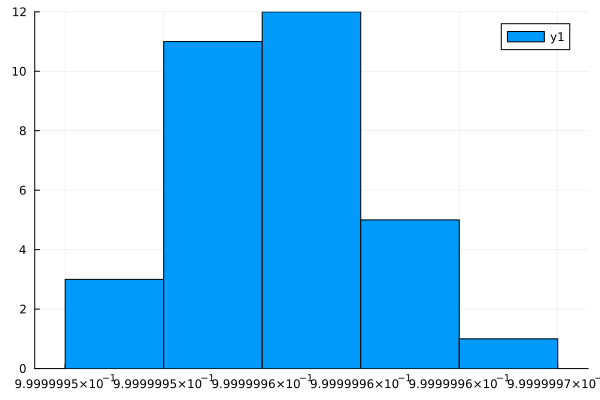

In [13]:
histogram( ss[:,:,:,end] |> vec)

In [14]:
qst.shape

(512, 32, 1)

In [15]:
kst = to_spk(k)
vst = to_spk(v)

Spike Train: (512, 20, 1) with 10240 spikes.

In [49]:
function similarity_outer(x::SpikeTrain, y::SpikeTrain, dims; tspan::Tuple{<:Real, <:Real} = (0.0, 10.0), spk_args::SpikingArgs = default_spk_args())
    sol_x = phase_memory(x, tspan = tspan, spk_args = spk_args)
    sol_y = phase_memory(y, tspan = tspan, spk_args = spk_args)

    u_x = normalize_potential.(Array(sol_x))
    u_y = normalize_potential.(Array(sol_y))

    #add up along the slices
    interference = [abs.(u_xs .+ u_ys) for u_xs in eachslice(u_x, dims=dims), u_ys in eachslice(u_y, dims=dims)]
    avg_sim = interference_similarity.(interference, 1)
    return avg_sim
end

similarity_outer (generic function with 3 methods)

In [43]:
intf = similarity_outer(qst, kst, 2)

32×20 Matrix{Array{Float32, 3}}:
 [0.0; 0.0; … ; 0.0; 0.0;;; 0.0; 0.0; … ; 1.0; 0.0;;; 0.0; 0.0; … ; 1.0; 0.0;;; … ;;; 1.37133; 1.49959; … ; 1.99605; 1.49959;;; 1.37133; 1.49959; … ; 1.99605; 1.49959;;; 1.37133; 1.49959; … ; 1.99605; 1.49959]              …  [0.0; 0.0; … ; 0.0; 0.0;;; 0.0; 0.0; … ; 1.0; 0.0;;; 0.0; 0.0; … ; 1.0; 0.0;;; … ;;; 0.43859; 0.962273; … ; 0.734786; 1.61755;;; 0.43859; 0.962273; … ; 0.734786; 1.61755;;; 0.43859; 0.962273; … ; 0.734786; 1.61755]
 [0.0; 0.0; … ; 0.0; 0.0;;; 0.0; 0.0; … ; 0.0; 0.0;;; 0.0; 0.0; … ; 0.0; 0.0;;; … ;;; 1.58231; 0.434548; … ; 0.434548; 1.27395;;; 1.58231; 0.434548; … ; 0.434548; 1.27395;;; 1.58231; 0.434548; … ; 0.434548; 1.27395]           [0.0; 0.0; … ; 0.0; 0.0;;; 0.0; 0.0; … ; 0.0; 0.0;;; 0.0; 0.0; … ; 0.0; 0.0;;; … ;;; 0.738636; 1.07053; … ; 1.95177; 1.41348;;; 0.738636; 1.07053; … ; 1.95177; 1.41348;;; 0.738636; 1.07053; … ; 1.95177; 1.41348]
 [0.0; 0.0; … ; 0.0; 0.0;;; 0.0; 0.0; … ; 0.0; 0.0;;; 0.0; 0.0; … ; 0.0; 0.0;;; … ;;; 1.

In [44]:
ints = interference_similarity.(intf, 1)

32×20 Matrix{Array{Float64, 3}}:
 [-1.0;;; -0.964844;;; -0.951172;;; … ;;; 0.027363;;; 0.027363;;; 0.027363]              …  [-1.0;;; -0.964844;;; -0.950195;;; … ;;; 0.00631644;;; 0.00631645;;; 0.00631645]
 [-1.0;;; -0.964844;;; -0.954102;;; … ;;; -0.0113427;;; -0.0113427;;; -0.0113427]           [-1.0;;; -0.964844;;; -0.953125;;; … ;;; -0.0226387;;; -0.0226386;;; -0.0226386]
 [-1.0;;; -0.968751;;; -0.956056;;; … ;;; 0.0114471;;; 0.0114471;;; 0.0114471]              [-1.0;;; -0.970703;;; -0.955078;;; … ;;; -0.0310326;;; -0.0310326;;; -0.0310326]
 [-1.0;;; -0.96875;;; -0.958984;;; … ;;; 0.00384751;;; 0.00384752;;; 0.00384753]            [-1.0;;; -0.96875;;; -0.95411;;; … ;;; 0.0464599;;; 0.0464599;;; 0.0464599]
 [-1.0;;; -0.962891;;; -0.956055;;; … ;;; 0.0192863;;; 0.0192863;;; 0.0192863]              [-1.0;;; -0.960938;;; -0.951174;;; … ;;; -0.0410076;;; -0.0410076;;; -0.0410076]
 [-1.0;;; -0.96582;;; -0.953125;;; … ;;; 0.0655437;;; 0.0655437;;; 0.0655437]            …  [-1.0;;; -0.961

In [50]:
ints2 = similarity_outer(qst, kst, 2);

In [45]:
so_s = [i[1,1,end] for i in ints]

32×20 Matrix{Float64}:
  0.027363      0.0171821   -0.0305645    …   0.0106061    0.00631645
 -0.0113427     0.0310937   -0.0462861        0.00191286  -0.0226386
  0.0114471     0.013312    -0.0179054        0.0155704   -0.0310326
  0.00384753   -0.0147158    0.0465013        0.0324986    0.0464599
  0.0192863     0.0155304   -0.0264014        0.0096151   -0.0410076
  0.0655437     0.0196495    0.027824     …  -0.013291    -0.00341029
 -0.0235613    -0.0107478    0.048582        -0.0117363    0.0411319
 -0.00851678    0.022033     0.00282574      -0.0481875   -0.000154988
  0.0384698    -0.0129865    0.0685929       -0.00653632   0.0188428
  0.0251894    -0.0409403   -0.00469569       0.0326052   -0.00157384
  ⋮                                       ⋱               
 -0.000318615  -0.0177787   -0.00381403       0.017969     0.0570635
  0.0345115    -0.0175545    0.00193963       0.00865572  -0.0299952
  0.0186696     0.0484572    0.0039956    …   0.0695192   -0.00221724
  0.0056802    

In [51]:
so_s2 = [i[1,1,end] for i in ints2]

32×20 Matrix{Float64}:
  0.027363      0.0171821   -0.0305645    …   0.0106061    0.00631645
 -0.0113427     0.0310937   -0.0462861        0.00191286  -0.0226386
  0.0114471     0.013312    -0.0179054        0.0155704   -0.0310326
  0.00384753   -0.0147158    0.0465013        0.0324986    0.0464599
  0.0192863     0.0155304   -0.0264014        0.0096151   -0.0410076
  0.0655437     0.0196495    0.027824     …  -0.013291    -0.00341029
 -0.0235613    -0.0107478    0.048582        -0.0117363    0.0411319
 -0.00851678    0.022033     0.00282574      -0.0481875   -0.000154988
  0.0384698    -0.0129865    0.0685929       -0.00653632   0.0188428
  0.0251894    -0.0409403   -0.00469569       0.0326052   -0.00157384
  ⋮                                       ⋱               
 -0.000318615  -0.0177787   -0.00381403       0.017969     0.0570635
  0.0345115    -0.0175545    0.00193963       0.00865572  -0.0299952
  0.0186696     0.0484572    0.0039956    …   0.0695192   -0.00221724
  0.0056802    

In [46]:
so = similarity_outer(q, k, 2);

In [47]:
err = vec(so_s) .- vec(so);

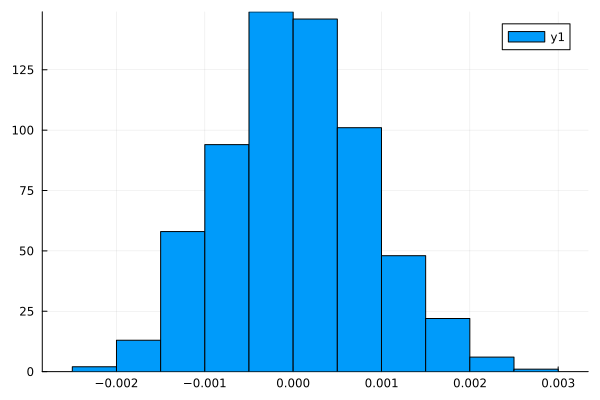

In [48]:
histogram(err)

In [35]:
intf[1,1]

1024×12×1001 Array{Float32, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮                        ⋮    
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [33]:
eachslice(uy, dims=2)

20-element Slices{Array{ComplexF32, 4}, Tuple{Colon, Int64, Colon, Colon}, Tuple{Base.OneTo{Int64}}, SubArray{ComplexF32, 3, Array{ComplexF32, 4}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64, Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}}, false}, 1}:
 [0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; … ; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im;;; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; … ; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im;;; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; … ; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f

In [32]:
eachslice(ux, dims=2)

32-element Slices{Array{ComplexF32, 4}, Tuple{Colon, Int64, Colon, Colon}, Tuple{Base.OneTo{Int64}}, SubArray{ComplexF32, 3, Array{ComplexF32, 4}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64, Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}}, false}, 1}:
 [0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; … ; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im;;; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; … ; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im;;; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 1.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; … ; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f

In [24]:
intf = similarity_outer(qst, kst, dims=2)

InterruptException: InterruptException:

In [52]:
length(qst)

32

In [53]:
qst[1]

Spike Train: (1024, 12) with 12288 spikes.

In [57]:
32 * 20 * 1.26 / 60

13.44

In [55]:
@time similarity(qst[1], kst[1])

  1.262636 seconds (178.44 k allocations: 3.833 GiB, 45.09% gc time)


1×12×1001 Array{Float64, 3}:
[:, :, 1] =
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0

[:, :, 2] =
 -0.977051  -0.967286  -0.969238  …  -0.969727  -0.970215  -0.970703

[:, :, 3] =
 -0.966309  -0.953614  -0.960449  …  -0.958497  -0.95752  -0.959476

;;; … 

[:, :, 999] =
 0.0405547  -0.017052  0.0293065  …  0.022592  -0.0194845  -0.00432414

[:, :, 1000] =
 0.0405547  -0.017052  0.0293065  …  0.022592  -0.0194845  -0.00432414

[:, :, 1001] =
 0.0405547  -0.017052  0.0293065  …  0.022592  -0.0194845  -0.00432415

In [6]:
s = similarity_outer(q, k, 2);

In [7]:
size(s)

(1, 12, 32, 20)

In [8]:
s2 = permutedims(dropdims(s, dims = 1), (3, 2, 1));

In [9]:
size(s2)

(20, 32, 12)

In [10]:
size(v)

(1024, 20, 12)

In [11]:
out = stack([v[:,:,i] * s2[:,:,i] for i in 1:12])

1024×32×12 Array{Float64, 3}:
[:, :, 1] =
  0.00448723  -0.00653469  -0.00556354  …   0.0415122    0.055871
 -0.0370624   -0.0103445    0.024857       -0.0381685   -0.0589181
  0.0266574   -0.0254915    0.030102        0.00499252  -0.0279366
 -0.115791     0.0552263   -0.0112466       0.0529826   -0.0157157
 -0.123506     0.067314     0.0679918       0.00787039  -0.053168
 -0.155348    -0.00350102  -0.11238     …   0.098146     0.0462475
  0.0692659   -0.0410733   -0.0324401       0.0113132    0.0216286
  0.120733    -0.0796205   -0.0300861      -0.139297    -0.00901197
 -0.0303514   -0.0168958    0.15645        -0.0553015   -0.0135638
  0.122592    -0.00430399  -0.0434011      -0.0852807   -0.0203009
  ⋮                                     ⋱   ⋮           
  0.0770868   -0.0609509   -0.01013     …  -0.124779    -0.0069553
  0.0256034    0.0690952   -0.0207939       0.0664515    0.0280814
 -0.164797     0.0441511   -0.00611371      0.0364136    0.0332374
 -0.0185437    0.0610442   -0.0

In [34]:
function attend(q::Array{<:Real, 3}, k::Array{<:Real, 3}, v::Array{<:Real, 3})
    #compute qk scores
    #produces (1 b qt kt)
    scores = similarity_outer(q, k, 2)
    #do complex-domain matrix multiply of values by scores (v kt b)
    v = angle_to_complex(v)
    #multiply each value by the scores across batch
    #(v kt b) * (kt qt b) ... (v kt) * (kt qt) over b
    output = stack([v[:,:,i] * scores[1,i,:,:]' for i in axes(v, 3)])
    output = complex_to_angle(output)
    return output
end

attend (generic function with 1 method)

In [35]:
o = attend(q, k, v)

1024×32×12 Array{Float64, 3}:
[:, :, 1] =
  0.629379  -0.248895   -0.544492   …  -0.47913     0.0108127   0.30807
 -0.183322  -0.936989   -0.476784      -0.459622   -0.881803    0.761893
  0.758434   0.0279775   0.919462      -0.958098    0.0429306  -0.736058
 -0.653921   0.27305     0.193063      -0.283528    0.0561197  -0.830254
 -0.376299   0.638185    0.212207       0.0565997  -0.877026   -0.536492
 -0.183314  -0.816998   -0.659797   …   0.853176    0.823513    0.784881
  0.492853  -0.536554   -0.422309       0.0188544   0.870229   -0.944896
  0.399795  -0.401621   -0.84961        0.918639   -0.384325    0.261315
  0.903878  -0.534895    0.483051       0.213593   -0.25983    -0.118994
  0.651333  -0.875254   -0.696104      -0.618873   -0.589389   -0.186112
  ⋮                                 ⋱               ⋮          
  0.930019  -0.614854   -0.0954248  …   0.620117   -0.57231     0.048574
  0.937981   0.583469   -0.229789       0.137679    0.262909    0.17598
 -0.452562   0.78013

In [36]:
using Zygote

In [37]:
loss = x -> 1.0 - sum(attend(x, k, v))

#177 (generic function with 1 method)

In [38]:
loss(q)

432.53193573456053

In [39]:
Zygote.withgradient(loss, q)

(val = 432.53193573456053, grad = ([-1.3872274396445838 5.535599697653429 … 0.07274544304305922 -0.7264506429641311; 3.367610048667346 -0.4566636753575979 … 0.3900693123984731 1.5657242959101958; … ; -0.2967968157596451 5.121489951686784 … -0.628608188607501 -7.463525564266382; 0.10241860523100552 2.823201881747603 … 0.3734453010442513 -0.6527956697882603;;; 2.0510042329547677 -0.4928855228744369 … 5.426352367394175 -1.9555548181036286; -0.08635254301180167 -4.726838053807041 … 2.335533092524195 1.8030559702734388; … ; 0.20379640440448557 -0.5910859538012595 … -1.4007800656401148 -0.5089498138455959; 0.06006373370040255 -0.0814765226921439 … -1.1216386488428995 0.7660185012041745;;; 1.4426357103224088 3.2450708082553947 … -1.2584495150914294 -1.7237166471967655; -1.3148231873366534 -9.002561371218238 … 3.5002398164956556 -0.2012105608812639; … ; -0.6479664736302172 8.456282025883468 … 0.012959342625881887 -1.2087316585016694; -1.127769541044354 -6.848139886752527 … 4.561819617266705 0.